
=== Epoch 1/50 ===


Train Loss: 5744.1508 | Val Loss: 5723.5004

=== Epoch 2/50 ===


Train Loss: 5713.5975 | Val Loss: 5709.1526

=== Epoch 3/50 ===


Train Loss: 5700.3801 | Val Loss: 5696.6057

=== Epoch 4/50 ===


Train Loss: 5689.1156 | Val Loss: 5684.4014

=== Epoch 5/50 ===


Train Loss: 5678.0741 | Val Loss: 5672.8959

=== Epoch 6/50 ===


Train Loss: 5669.3815 | Val Loss: 5660.8941

=== Epoch 7/50 ===


Train Loss: 5658.9417 | Val Loss: 5650.3048

=== Epoch 8/50 ===


Train Loss: 5650.8460 | Val Loss: 5642.7633

=== Epoch 9/50 ===


Train Loss: 5643.9554 | Val Loss: 5634.7795

=== Epoch 10/50 ===


Train Loss: 5637.9192 | Val Loss: 5628.3463

=== Epoch 11/50 ===


Train Loss: 5632.6293 | Val Loss: 5622.7390

=== Epoch 12/50 ===


Train Loss: 5627.7567 | Val Loss: 5618.7901

=== Epoch 13/50 ===


Train Loss: 5624.3469 | Val Loss: 5614.1819

=== Epoch 14/50 ===


Train Loss: 5619.3034 | Val Loss: 5609.0781

=== Epoch 15/50 ===


Train Loss: 5616.1355 | Val Loss: 5605.4539

=== Epoch 16/50 ===


Train Loss: 5612.3823 | Val Loss: 5601.4068

=== Epoch 17/50 ===


Train Loss: 5609.1373 | Val Loss: 5597.4923

=== Epoch 18/50 ===


Train Loss: 5605.5698 | Val Loss: 5594.5992

=== Epoch 19/50 ===


Train Loss: 5602.9471 | Val Loss: 5590.8593

=== Epoch 20/50 ===


Train Loss: 5600.1279 | Val Loss: 5587.9299

=== Epoch 21/50 ===


Train Loss: 5596.3564 | Val Loss: 5584.2959

=== Epoch 22/50 ===


Train Loss: 5593.8415 | Val Loss: 5581.8357

=== Epoch 23/50 ===


Train Loss: 5590.8296 | Val Loss: 5578.6528

=== Epoch 24/50 ===


Train Loss: 5589.0384 | Val Loss: 5576.0150

=== Epoch 25/50 ===


Train Loss: 5585.1844 | Val Loss: 5574.6165

=== Epoch 26/50 ===


Train Loss: 5582.4328 | Val Loss: 5570.2749

=== Epoch 27/50 ===


Train Loss: 5584.3599 | Val Loss: 5569.3997

=== Epoch 28/50 ===


Train Loss: 5578.2971 | Val Loss: 5564.8777

=== Epoch 29/50 ===


Train Loss: 5575.3952 | Val Loss: 5561.3598

=== Epoch 30/50 ===


Train Loss: 5573.6404 | Val Loss: 5558.1563

=== Epoch 31/50 ===


Train Loss: 5569.9524 | Val Loss: 5555.9953

=== Epoch 32/50 ===


Train Loss: 5567.8609 | Val Loss: 5553.6278

=== Epoch 33/50 ===


Train Loss: 5566.2455 | Val Loss: 5551.0560

=== Epoch 34/50 ===


Train Loss: 5564.9189 | Val Loss: 5552.6884

=== Epoch 35/50 ===


Train Loss: 5561.4501 | Val Loss: 5553.2296

=== Epoch 36/50 ===


Train Loss: 5559.4809 | Val Loss: 5544.1828

=== Epoch 37/50 ===


Train Loss: 5557.1373 | Val Loss: 5542.1668

=== Epoch 38/50 ===


Train Loss: 5555.7993 | Val Loss: 5541.3381

=== Epoch 39/50 ===


Train Loss: 5553.3886 | Val Loss: 5538.1890

=== Epoch 40/50 ===


Train Loss: 5551.4229 | Val Loss: 5535.0892

=== Epoch 41/50 ===


Train Loss: 5550.1159 | Val Loss: 5532.9098

=== Epoch 42/50 ===


Train Loss: 5549.6148 | Val Loss: 5530.9988

=== Epoch 43/50 ===


Train Loss: 5546.2894 | Val Loss: 5528.4566

=== Epoch 44/50 ===


Train Loss: 5546.6054 | Val Loss: 5528.0991

=== Epoch 45/50 ===


Train Loss: 5542.5869 | Val Loss: 5524.4788

=== Epoch 46/50 ===


Train Loss: 5542.0283 | Val Loss: 5524.4295

=== Epoch 47/50 ===


Train Loss: 5539.1790 | Val Loss: 5525.0175

=== Epoch 48/50 ===


Train Loss: 5537.9783 | Val Loss: 5525.8633

=== Epoch 49/50 ===


Train Loss: 5535.9296 | Val Loss: 5518.4345

=== Epoch 50/50 ===


Train Loss: 5534.3928 | Val Loss: 5516.2311


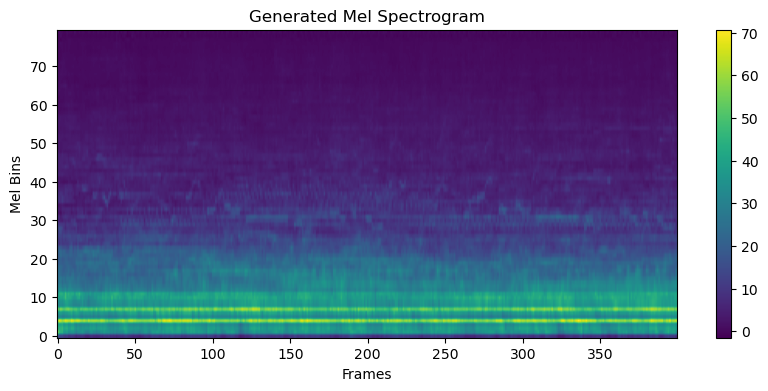

In [17]:
# ========== Imports ==========
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torch.utils.data import Dataset, DataLoader, random_split
import json
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from transformers import T5Tokenizer, T5EncoderModel

# ========== Multi-Resolution STFT Loss ==========
class MultiResolutionSTFTLoss(nn.Module):
    def __init__(self, fft_sizes=[512, 1024, 2048], hop_sizes=[128, 256, 512], win_lengths=[512, 1024, 2048]):
        super().__init__()
        assert len(fft_sizes) == len(hop_sizes) == len(win_lengths)
        self.fft_sizes = fft_sizes
        self.hop_sizes = hop_sizes
        self.win_lengths = win_lengths
        self.window = nn.ParameterDict({
            str(fft): nn.Parameter(torch.hann_window(win, requires_grad=False), requires_grad=False)
            for fft, win in zip(fft_sizes, win_lengths)
        })

    def stft(self, x, fft_size, hop_size, win_length, window):
        return torch.stft(
            x, n_fft=fft_size, hop_length=hop_size, win_length=win_length,
            window=window.to(x.device), return_complex=True
        )

    def spectral_convergence_loss(self, x_mag, y_mag):
        return torch.norm(y_mag - x_mag, p='fro') / torch.norm(y_mag, p='fro')

    def log_stft_magnitude_loss(self, x_mag, y_mag):
        return F.l1_loss(torch.log(x_mag + 1e-7), torch.log(y_mag + 1e-7))

    def forward(self, x, y):
        sc_loss = 0.0
        mag_loss = 0.0
        for fft_size, hop_size, win_length in zip(self.fft_sizes, self.hop_sizes, self.win_lengths):
            window = self.window[str(fft_size)]
            x_stft = self.stft(x, fft_size, hop_size, win_length, window)
            y_stft = self.stft(y, fft_size, hop_size, win_length, window)

            x_mag = torch.abs(x_stft)
            y_mag = torch.abs(y_stft)

            sc_loss += self.spectral_convergence_loss(x_mag, y_mag)
            mag_loss += self.log_stft_magnitude_loss(x_mag, y_mag)

        sc_loss /= len(self.fft_sizes)
        mag_loss /= len(self.fft_sizes)
        return sc_loss + mag_loss

# ========== Dataset ==========
class MusicBenchDataset(Dataset):
    def __init__(self, json_path, audio_base_path, tokenizer, max_length=512, sample_rate=16000, n_mels=80, frames=400, hop_size=256):
        self.data = []
        with open(json_path, 'r') as f:
            for line in f:
                self.data.append(json.loads(line))  # JSON lines format

        self.audio_base_path = audio_base_path
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.sample_rate = sample_rate
        self.n_mels = n_mels
        self.frames = frames
        self.hop_size = hop_size
        self.mel_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=self.sample_rate, n_mels=self.n_mels, hop_length=self.hop_size
        )

    def fix_mel_length(self, mel):
        n_mels, frames = mel.shape
        if frames > self.frames:
            mel = mel[:, :self.frames]
        elif frames < self.frames:
            pad = torch.zeros((n_mels, self.frames - frames))
            mel = torch.cat([mel, pad], dim=1)
        return mel

    def fix_wav_length(self, wav):
        target_length = self.frames * self.hop_size
        if wav.shape[0] > target_length:
            wav = wav[:target_length]
        elif wav.shape[0] < target_length:
            pad = torch.zeros(target_length - wav.shape[0])
            wav = torch.cat([wav, pad])
        return wav

    def preprocess_audio(self, filepath):
        waveform, sr = torchaudio.load(filepath)
        if sr != self.sample_rate:
            waveform = torchaudio.functional.resample(waveform, sr, self.sample_rate)

        mel = self.mel_transform(waveform).squeeze(0)  # (n_mels, time)
        mel = self.fix_mel_length(mel)
        waveform = waveform.squeeze(0)  # (samples)
        waveform = self.fix_wav_length(waveform)

        return mel, waveform

    def preprocess_text(self, item):
        text = f"{item['main_caption']} {item['alt_caption']} {item['prompt_bpm']} {item['prompt_key']} {item['prompt_bt']} {item['prompt_ch']}"
        return text

    def __getitem__(self, idx):
        item = self.data[idx]
        audio_path = os.path.join(self.audio_base_path, item['location'])

        mel, wav = self.preprocess_audio(audio_path)

        text = self.preprocess_text(item)
        text_inputs = self.tokenizer(text, padding='max_length', truncation=True, max_length=self.max_length, return_tensors='pt')

        bpm = item['bpm'] or 120.0
        bpm = float(bpm) / 300.0  # normalize

        return {
            'input_ids': text_inputs['input_ids'].squeeze(0),
            'attention_mask': text_inputs['attention_mask'].squeeze(0),
            'bpm': torch.tensor(bpm, dtype=torch.float32),
            'mel': mel,
            'wav': wav
        }

    def __len__(self):
        return len(self.data)

# ========== Text-to-Mel Model ==========
class TextToMelModel(nn.Module):
    def __init__(self, text_embed_dim, mel_bins=80, frames=400):
        super().__init__()
        self.frames = frames
        self.fc = nn.Sequential(
            nn.Linear(text_embed_dim + 1, 1024),
            nn.ReLU(),
            nn.Linear(1024, mel_bins * frames)
        )
        self.mel_bins = mel_bins

    def forward(self, text_embeddings, bpm):
        x = torch.cat([text_embeddings, bpm.unsqueeze(1)], dim=1)
        output = self.fc(x)
        output = output.view(-1, self.mel_bins, self.frames)
        return output

# ========== SimpleMel2Wav Vocoder ==========
class SimpleMel2Wav(nn.Module):
    def __init__(self, n_mels=80, upsample_scales=[8, 8, 4, 1]):
        super().__init__()
        self.initial = nn.Conv1d(n_mels, 512, kernel_size=7, padding=3)
        layers = []
        in_channels = 512
        for scale in upsample_scales:
            layers.append(nn.ConvTranspose1d(
                in_channels, in_channels // 2, kernel_size=scale * 2, stride=scale, padding=scale // 2))
            layers.append(nn.LeakyReLU(0.2))
            in_channels = in_channels // 2
        self.upsample = nn.Sequential(*layers)
        self.final = nn.Conv1d(in_channels, 1, kernel_size=7, padding=3)
        self.tanh = nn.Tanh()

    def forward(self, mel):
        x = self.initial(mel)
        x = self.upsample(x)
        x = self.final(x)
        x = self.tanh(x)
        x = x.squeeze(1)
        return x

# ========== Helper: Plot Mel Spectrogram ==========
def plot_mel(mel, title="Mel Spectrogram"):
    plt.figure(figsize=(10, 4))
    plt.imshow(mel.cpu().detach().numpy(), aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel("Frames")
    plt.ylabel("Mel Bins")
    plt.colorbar()
    plt.show()

# ========== Training ==========
def train(mel_model, vocoder_model, text_encoder, dataloader, optimizer, mel_loss_fn, wav_loss_fn, device):
    mel_model.train()
    vocoder_model.train()
    text_encoder.eval()

    total_loss = 0
    pbar = tqdm(dataloader, desc="Training", leave=False)
    for batch in pbar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        bpm = batch['bpm'].to(device)
        mel_target = batch['mel'].to(device)
        wav_target = batch['wav'].to(device)

        with torch.no_grad():
            text_outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
            text_embeds = text_outputs.last_hidden_state.mean(dim=1)

        mel_pred = mel_model(text_embeds, bpm)
        wav_pred = vocoder_model(mel_pred)

        mel_loss = mel_loss_fn(mel_pred, mel_target)

        if wav_pred.shape[1] != wav_target.shape[1]:
            min_len = min(wav_pred.shape[1], wav_target.shape[1])
            wav_pred = wav_pred[:, :min_len]
            wav_target = wav_target[:, :min_len]

        wav_loss = wav_loss_fn(wav_pred, wav_target)

        loss = mel_loss + wav_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# ========== Evaluation ==========
def evaluate(mel_model, vocoder_model, text_encoder, dataloader, mel_loss_fn, wav_loss_fn, device):
    mel_model.eval()
    vocoder_model.eval()
    text_encoder.eval()

    total_loss = 0
    pbar = tqdm(dataloader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            bpm = batch['bpm'].to(device)
            mel_target = batch['mel'].to(device)
            wav_target = batch['wav'].to(device)

            text_outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
            text_embeds = text_outputs.last_hidden_state.mean(dim=1)

            mel_pred = mel_model(text_embeds, bpm)
            wav_pred = vocoder_model(mel_pred)

            mel_loss = mel_loss_fn(mel_pred, mel_target)

            if wav_pred.shape[1] != wav_target.shape[1]:
                min_len = min(wav_pred.shape[1], wav_target.shape[1])
                wav_pred = wav_pred[:, :min_len]
                wav_target = wav_target[:, :min_len]

            wav_loss = wav_loss_fn(wav_pred, wav_target)

            loss = mel_loss + wav_loss
            total_loss += loss.item()
            pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    return avg_loss

# ========== Inference ==========
def generate(mel_model, vocoder_model, text_encoder, tokenizer, text_prompt, bpm_value, device):
    mel_model.eval()
    vocoder_model.eval()
    text_encoder.eval()

    inputs = tokenizer(text_prompt, return_tensors='pt', padding='max_length', truncation=True, max_length=512)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    bpm_tensor = torch.tensor([bpm_value / 300.0], dtype=torch.float32).to(device)

    with torch.no_grad():
        text_outputs = text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_embeds = text_outputs.last_hidden_state.mean(dim=1)

        mel_pred = mel_model(text_embeds, bpm_tensor)
        plot_mel(mel_pred.squeeze(0), title="Generated Mel Spectrogram")

        wav = vocoder_model(mel_pred)
        return wav

# ========== Main ==========
def main():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    tokenizer = T5Tokenizer.from_pretrained('t5-small')
    text_encoder = T5EncoderModel.from_pretrained('t5-small').to(device)

    json_path = 'MusicBench_train.json'
    audio_base_path = 'datashare'

    full_dataset = MusicBenchDataset(
        json_path=json_path,
        audio_base_path=audio_base_path,
        tokenizer=tokenizer
    )

    train_size = int(0.9 * len(full_dataset))
    val_size = len(full_dataset) - train_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

    mel_model = TextToMelModel(text_embed_dim=512, mel_bins=80, frames=400).to(device)
    vocoder_model = SimpleMel2Wav(n_mels=80).to(device)

    optimizer = torch.optim.Adam(list(mel_model.parameters()) + list(vocoder_model.parameters()), lr=1e-4)
    mel_loss_fn = nn.MSELoss()
    wav_loss_fn = MultiResolutionSTFTLoss()

    epochs = 50
    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} ===")
        train_loss = train(mel_model, vocoder_model, text_encoder, train_loader, optimizer, mel_loss_fn, wav_loss_fn, device)
        val_loss = evaluate(mel_model, vocoder_model, text_encoder, val_loader, mel_loss_fn, wav_loss_fn, device)
        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Inference Example
    example_text = "A calm piano melody with a soft beat and slow tempo in C major."
    bpm_value = 90.0
    wav = generate(mel_model, vocoder_model, text_encoder, tokenizer, example_text, bpm_value, device)

    if wav is not None:
        wav = wav.squeeze(0).unsqueeze(0)  # [channels=1, time]
        torchaudio.save('generated_output.wav', wav.cpu(), 16000)

if __name__ == "__main__":
    main()
